# Linear Regression Analysis and Prediction for CAT (Counter attack turret)

This notebook processes the synthetic CAT counter data using linear regression to make predictions for our CAT counter data. Linear regression predictions will be used to see if we can predict when the cat will jump onto the counter.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [46]:
#use this cell to import additional libraries or define helper functions

from google.colab import drive

# library to standardize dates
from dateutil.parser import parse
from datetime import datetime
import math

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [47]:
#Load your data into a pandas dataframe here

df = pd.read_csv("/content/drive/MyDrive/AAI530_IOT/cat_counter_data_10000.csv", delimiter = ",")

In [48]:
# column names from synthetic data
# timestamp	is_counter_access_attempted	last_feeding_time	next_feeding_time
# convert timestamps into epoch/unix
# print(df.columns) - had a brief issue with separator, used this to debug,.
SECONDS_CONVERSION_RATE = 10**9 # conversion rate because the int64 version is off by several 0's due to nanoseconds conversion.

print(df.head())
print(df.columns)
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['last_feeding_time'] = pd.to_datetime(df['last_feeding_time'], errors='coerce')
df['next_feeding_time'] = pd.to_datetime(df['next_feeding_time'], errors='coerce')

df['timestamp_as_unix'] = df['timestamp'].astype(np.int64) // SECONDS_CONVERSION_RATE
df['last_feeding_time_as_unix'] = df['last_feeding_time'].astype(np.int64) // SECONDS_CONVERSION_RATE
df['next_feeding_time_as_unix'] = df['next_feeding_time'].astype(np.int64) // SECONDS_CONVERSION_RATE

             timestamp  is_counter_access_attempted    last_feeding_time  \
0  2023-01-01 00:00:00                         True  2022-12-31 21:00:00   
1  2023-01-01 00:01:00                        False  2022-12-31 21:00:00   
2  2023-01-01 00:02:00                        False  2022-12-31 21:00:00   
3  2023-01-01 00:03:00                        False  2022-12-31 21:00:00   
4  2023-01-01 00:04:00                        False  2022-12-31 21:00:00   

     next_feeding_time  
0  2023-01-01 08:00:00  
1  2023-01-01 08:00:00  
2  2023-01-01 08:00:00  
3  2023-01-01 08:00:00  
4  2023-01-01 08:00:00  
Index(['timestamp', 'is_counter_access_attempted', 'last_feeding_time',
       'next_feeding_time'],
      dtype='object')


## Predicting boolean is_counter_access_attempted

We will try to predict the counter access attempts with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: pH is the predictive horizon. It is how far out we are making our
predictions. Mu is the forgetting factor, which exponentially decays the data from the history. This is so that once we have a certain amount of data built up, we don't want to make predictions off the whole range of data.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [49]:
ts = pd.DataFrame(df.timestamp_as_unix)
ys = pd.DataFrame(df['is_counter_access_attempted'].astype(int))

ph = 300 #5 minutes, or 300 seconds since our unix time is in seconds.
ph_index = math.ceil(ph/df.timestamp_as_unix.diff().mean())
# ph/data resolution (how many timesteps is our ph?)
# data resolution is about 1 minute (60.76 seconds) between each measurement, so we end up with ~ 5 for our ph_index. Since below MSE calculations needs an integer, rounding this to 5.
print(ph_index)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

5


**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: My understanding is that the first data point will have almost no weight on the 5000th prediction. This is because 0.9 mu gives us the following series:

First prediction: weight = 0.1 (the weight of past observations decreases by (1-mu))
Second prediction: weight = 0.1 * 0.9 = 0.09
...
5000th prediction: 0.1 * 0.9^4999 ~= 0

so it should be little to no weight on the 5000th prediction.

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [50]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

for i in range(2, n_s+1):# start out with 2 leading datapoints
  #get x and y data "available" for our prediction
  ts_tmp = ts[0:i]
  ys_tmp = ys[0:i]
  ns = len(ys_tmp)


  weights = np.ones(ns)*mu
  for k in range(ns):
      #adjust weights to be downweighted according to their timestep away from our prediction
      weights[k] = weights[k]**k
  weights = np.flip(weights, 0)

  #perform linear regression on "available" data using the mu-adjusted weights
  lm_tmp = LinearRegression()
  model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

  #store model coefficients and intercepts to compute prediction
  m_tmp = model_tmp.coef_
  q_tmp = model_tmp.intercept_

  #use ph to make the model prediction according to the prediction time
  tp = ts.iloc[i-1, 0] + ph # next time stamp
  yp = m_tmp*tp + q_tmp # mx +b

  tp_pred[i-2] = tp
  yp_pred[i-2] = yp


Now let's visualize the results from our model.

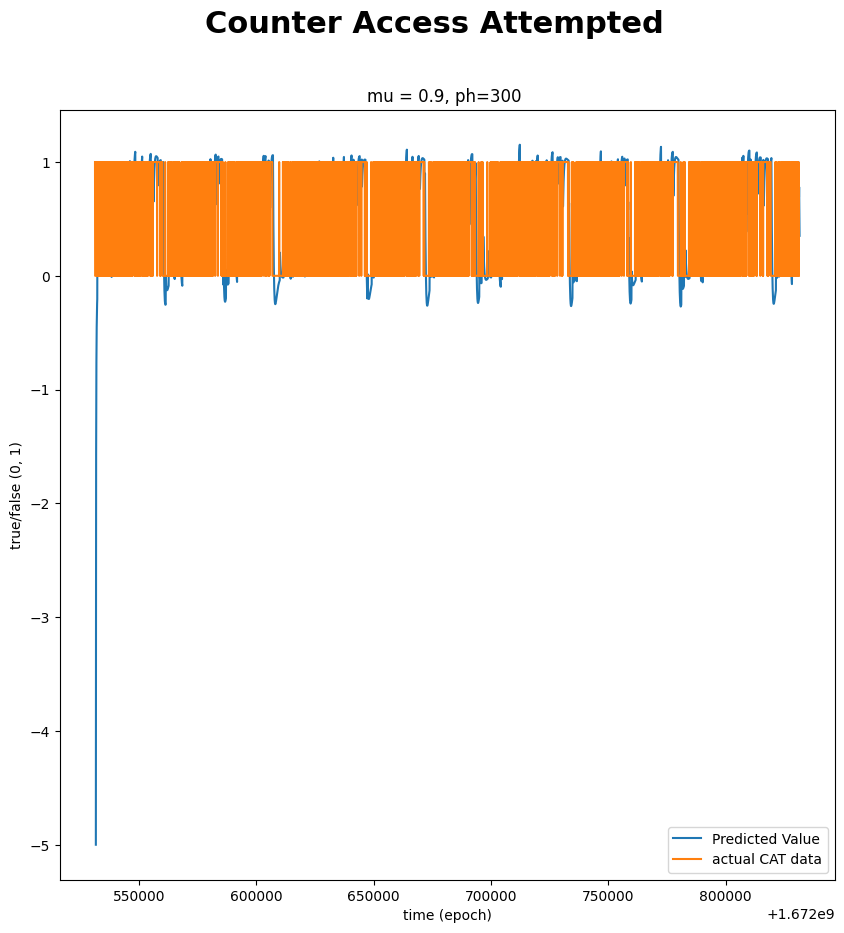

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Counter Access Attempted', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value')
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='actual CAT data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('true/false (0, 1)')
ax.legend()

Visualizing last 100 and first 100 datapoints

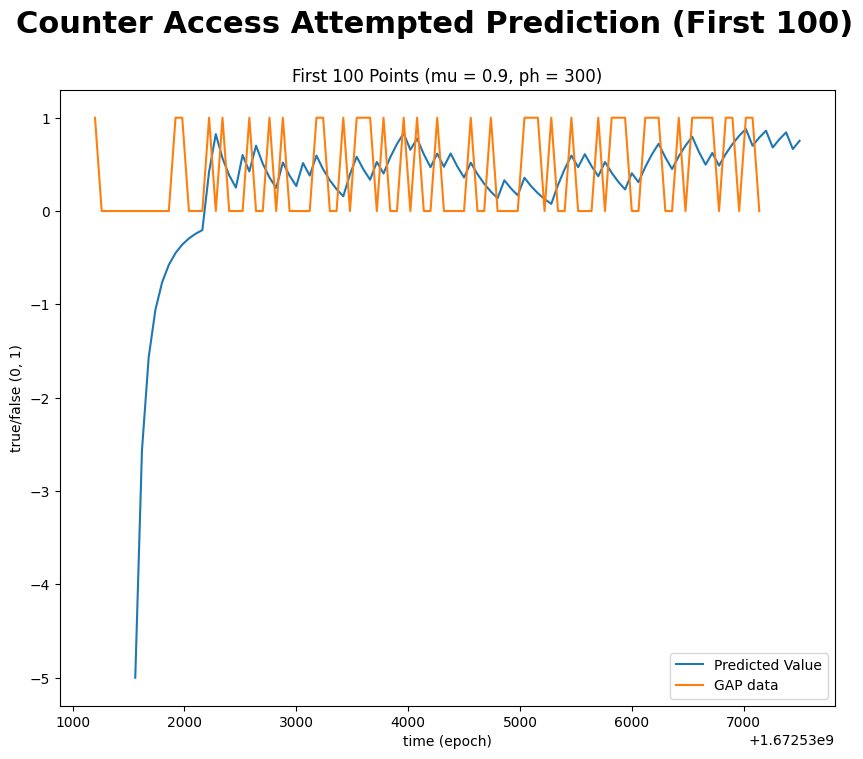

In [52]:
#Plot first 100 data points/predictions
fig1, ax1 = plt.subplots(figsize=(10, 8))
fig1.suptitle('Counter Access Attempted Prediction (First 100)', fontsize=22, fontweight='bold')
ax1.set_title(f'First 100 Points (mu = {mu}, ph = {ph})')
ax1.plot(tp_pred[:100], yp_pred[:100], label='Predicted Value')
ax1.plot(ts.iloc[0:100,0], ys.iloc[0:100,0], label='GAP data')
ax1.set_xlabel('time (epoch)')
ax1.set_ylabel('true/false (0, 1)')
ax1.legend()

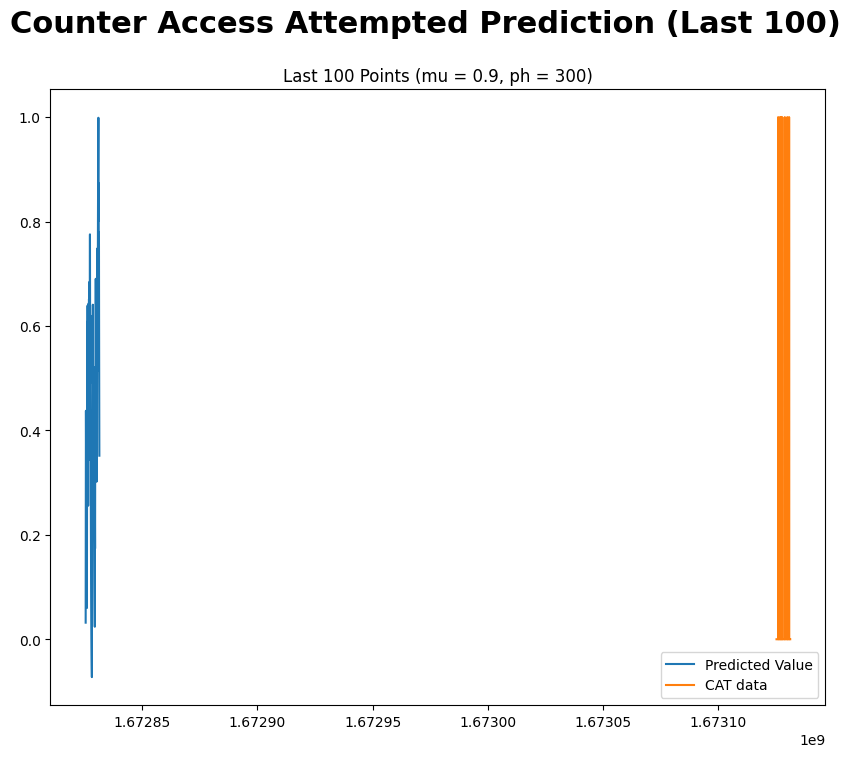

In [53]:
#Plot last 100 data points/predictions
fig1, ax2 = plt.subplots(figsize=(10, 8))
fig1.suptitle('Counter Access Attempted Prediction (Last 100)', fontsize=22, fontweight='bold')
ax2.set_title(f'Last 100 Points (mu = {mu}, ph = {ph})')
ax2.plot(tp_pred[-100:], yp_pred[-100:], label='Predicted Value')
ax2.plot(ts.iloc[-100:,0], ys.iloc[-100:,0], label='CAT data')
ax1.set_xlabel('time (epoch)')
ax1.set_ylabel('true/false (0, 1)')
ax2.legend()

In [55]:
#Calculate MSE of predictions
from sklearn.metrics import mean_squared_error as mse
print("MSE is", mse(ys['is_counter_access_attempted'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.22694468172302648


MSE of 0.227 is okay given our range of values for true/false is 0 to 1.

early predictions are more aligned, later predictions don't seem to be at all.

In [56]:
#Re-run prediction code for mu = 1

mu = 1 # normally would create a function for this for loop, but since it ends after these two runs just copying over.

for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1, 0] + ph # next time stamp
    yp = m_tmp*tp + q_tmp # mx +b

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

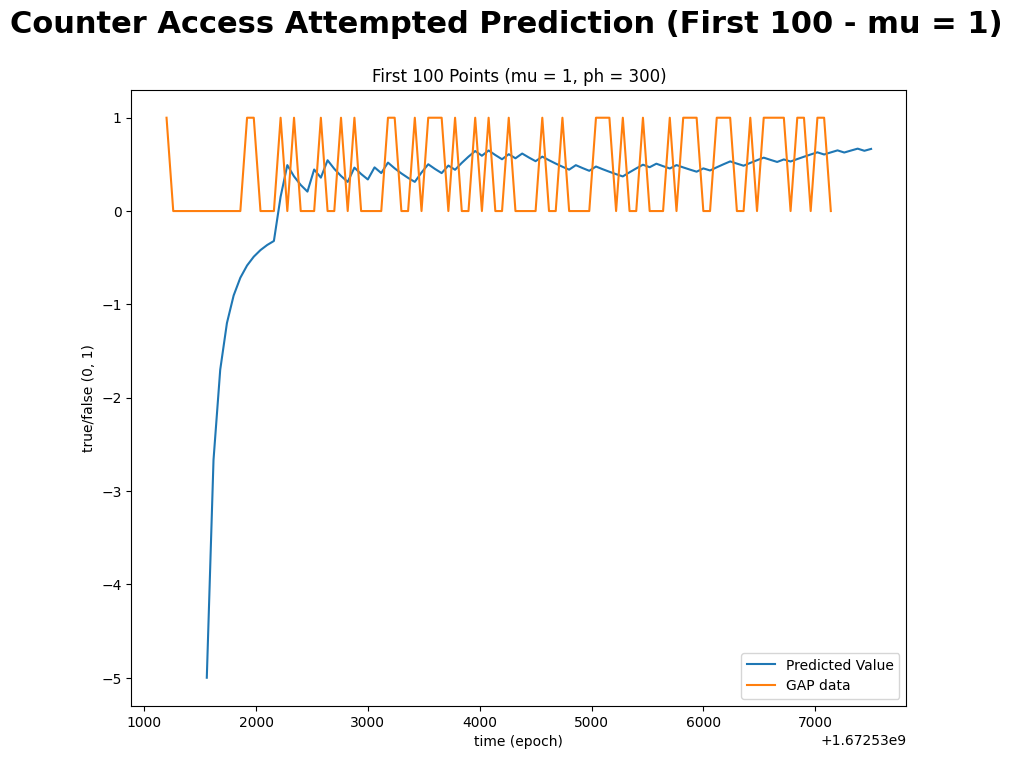

In [57]:
#Plot first 100 data points/predictions for mu = 1
fig1, ax1 = plt.subplots(figsize=(10, 8))
fig1.suptitle('Counter Access Attempted Prediction (First 100 - mu = 1)', fontsize=22, fontweight='bold')
ax1.set_title(f'First 100 Points (mu = {mu}, ph = {ph})')
ax1.plot(tp_pred[:100], yp_pred[:100], label='Predicted Value')
ax1.plot(ts.iloc[0:100,0], ys.iloc[0:100,0], label='GAP data')
ax1.set_xlabel('time (epoch)')
ax1.set_ylabel('true/false (0, 1)')
ax1.legend()

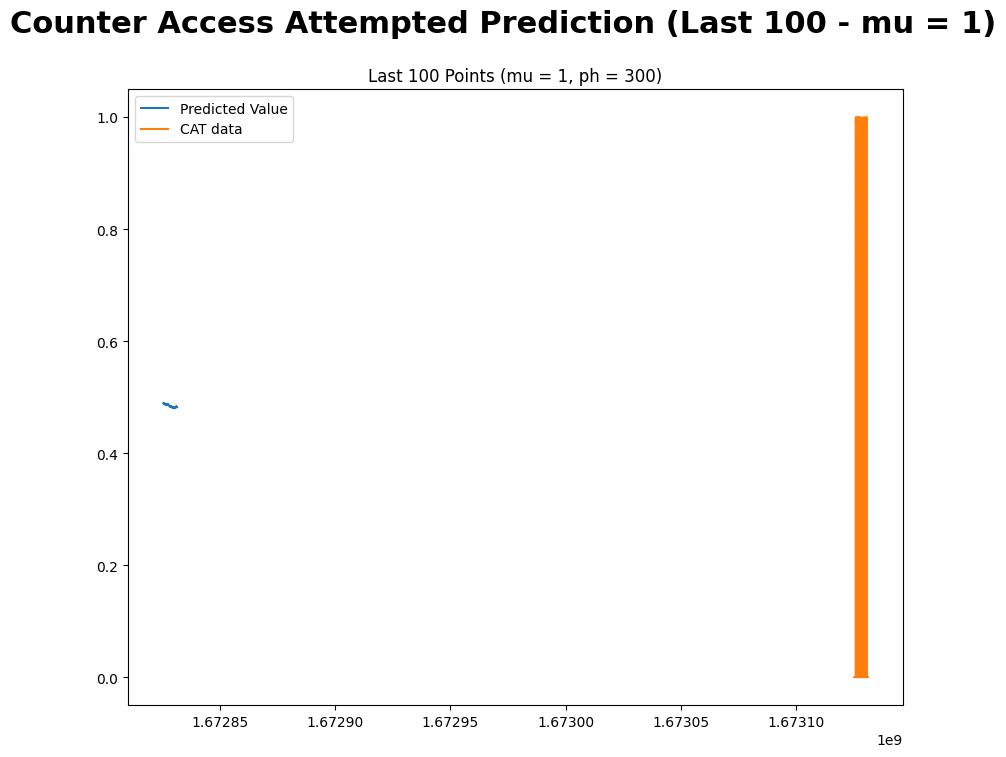

In [58]:
#Plot last 100 data points/predictions for mu = 1
fig1, ax2 = plt.subplots(figsize=(10, 8))
fig1.suptitle('Counter Access Attempted Prediction (Last 100 - mu = 1)', fontsize=22, fontweight='bold')
ax2.set_title(f'Last 100 Points (mu = {mu}, ph = {ph})')
ax2.plot(tp_pred[-100:], yp_pred[-100:], label='Predicted Value')
ax2.plot(ts.iloc[-100:,0], ys.iloc[-100:,0], label='CAT data')
ax1.set_xlabel('time (epoch)')
ax1.set_ylabel('true/false (0, 1)')
ax2.legend()

In [59]:
#Calculate MSE of predictions for mu = 1
print("MSE is", mse(ys['is_counter_access_attempted'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.2603835170288461


In [60]:
#Re-run prediction code for mu = 0.01
mu = 0.01 # normally would create a function for this for loop, but since it ends after these two runs just copying over.

for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1, 0] + ph # next time stamp
    yp = m_tmp*tp + q_tmp # mx +b

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

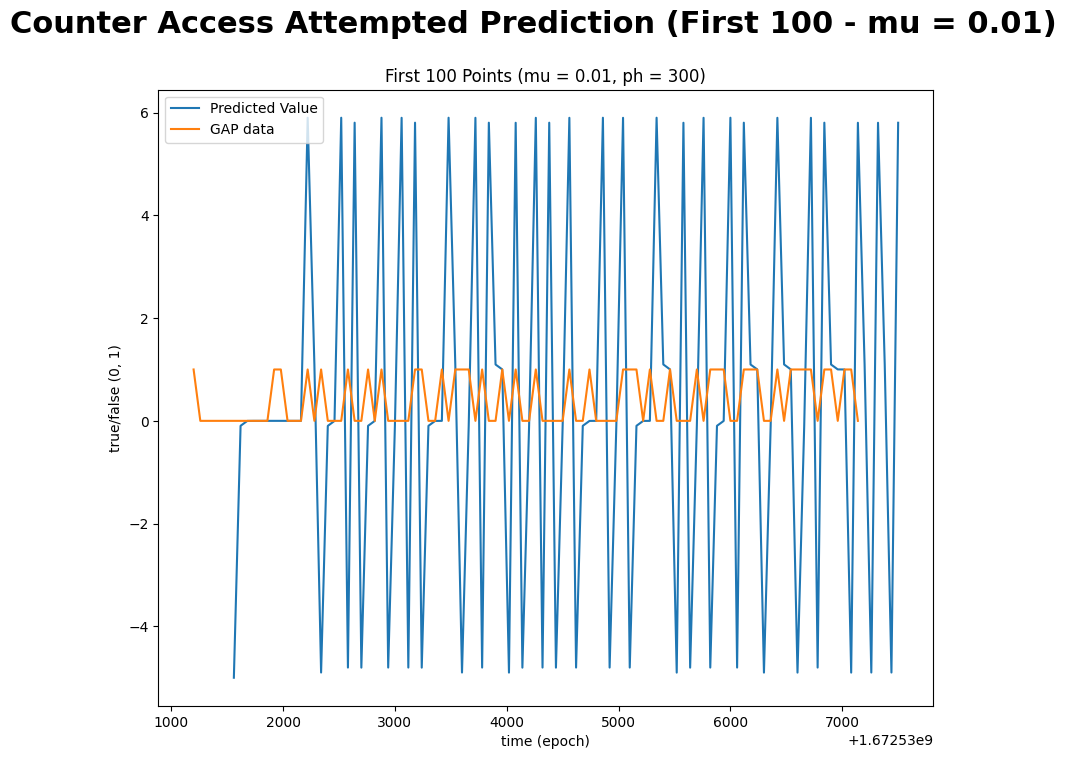

In [61]:
#Plot first 100 data points/predictions for mu = 1
fig1, ax1 = plt.subplots(figsize=(10, 8))
fig1.suptitle('Counter Access Attempted Prediction (First 100 - mu = 0.01)', fontsize=22, fontweight='bold')
ax1.set_title(f'First 100 Points (mu = {mu}, ph = {ph})')
ax1.plot(tp_pred[:100], yp_pred[:100], label='Predicted Value')
ax1.plot(ts.iloc[0:100,0], ys.iloc[0:100,0], label='GAP data')
ax1.set_xlabel('time (epoch)')
ax1.set_ylabel('true/false (0, 1)')
ax1.legend()

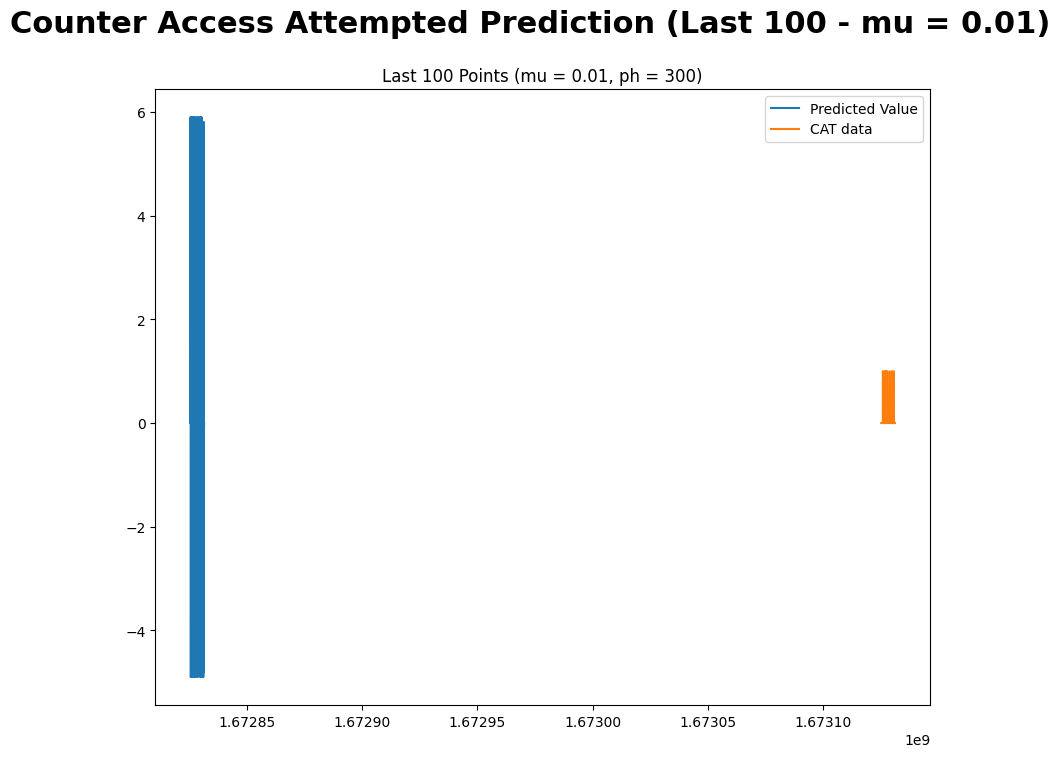

In [62]:
#Plot last 100 data points/predictions for mu = 0.01
fig1, ax2 = plt.subplots(figsize=(10, 8))
fig1.suptitle('Counter Access Attempted Prediction (Last 100 - mu = 0.01)', fontsize=22, fontweight='bold')
ax2.set_title(f'Last 100 Points (mu = {mu}, ph = {ph})')
ax2.plot(tp_pred[-100:], yp_pred[-100:], label='Predicted Value')
ax2.plot(ts.iloc[-100:,0], ys.iloc[-100:,0], label='CAT data')
ax1.set_xlabel('time (epoch)')
ax1.set_ylabel('true/false (0, 1)')
ax2.legend()

In [63]:
#Calculate MSE of predictions for mu = 0.01
print("MSE is", mse(ys['is_counter_access_attempted'][ph_index:5000+ph_index-1],yp_pred))

MSE is 10.466327391531049


Based on these findings, our original mu value of 0.9 performed the best. (Lower MSE is better)

In [69]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame({
    'timestamp': df.timestamp_as_unix,
    'last_feeding_time': df.last_feeding_time_as_unix,
    'next_feeding_time': df.next_feeding_time_as_unix
    }) # updating to add voltage
ys = pd.DataFrame(df.is_counter_access_attempted)

ph = 300 #5 minutes
ph_index = math.ceil(ph/df.timestamp_as_unix.diff().mean())
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [70]:
#run the prediction code on your expanded dataset

for i in range(2, n_s+1):
    # get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)

    weights = np.ones(ns)*mu
    for k in range(ns):
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)

    # perform linear regression
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # store model coefficients and intercepts
    coefficients = model_tmp.coef_[0]  # This will now be an array of time and voltage
    q_tmp = model_tmp.intercept_[0]

    # Make prediction using both time and voltage
    next_time = ts.iloc[i-1, 0] + ph  # next time stamp
    next_voltage = ts.iloc[i-1, 1]    # use current voltage

    # Calculate prediction including both time/voltage coefficients
    yp = coefficients[0]*next_time + coefficients[1]*next_voltage + q_tmp

    tp_pred[i-2] = next_time
    yp_pred[i-2] = yp

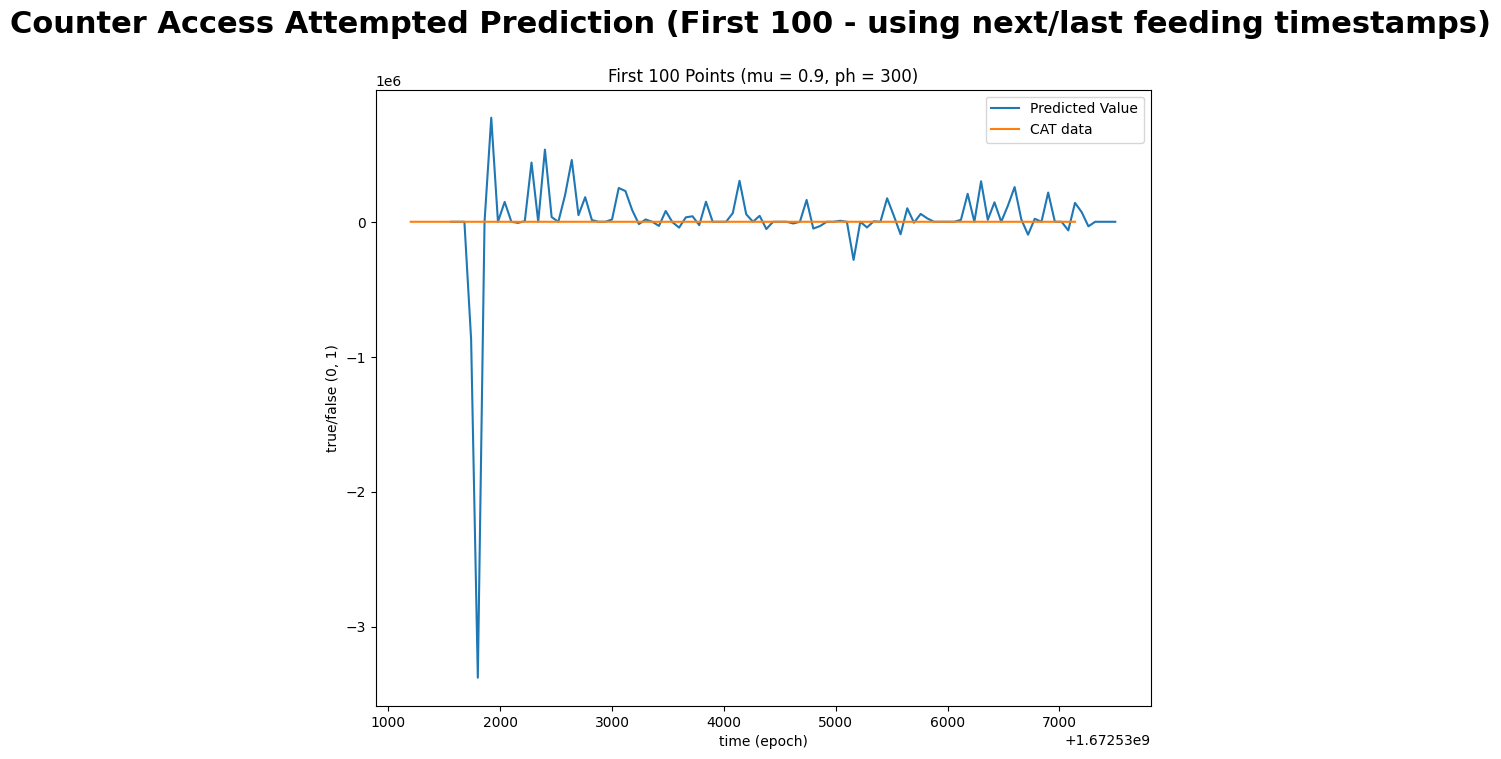

In [71]:
#Plot first 100 data points/predictions for expanded

fig1, ax1 = plt.subplots(figsize=(10, 8))
fig1.suptitle('Counter Access Attempted Prediction (First 100 - using next/last feeding timestamps)', fontsize=22, fontweight='bold')
ax1.set_title(f'First 100 Points (mu = {mu}, ph = {ph})')
ax1.plot(tp_pred[:100], yp_pred[:100], label='Predicted Value')
ax1.plot(ts.iloc[0:100,0], ys.iloc[0:100,0], label='CAT data')
ax1.set_xlabel('time (epoch)')
ax1.set_ylabel('true/false (0, 1)')
ax1.legend()

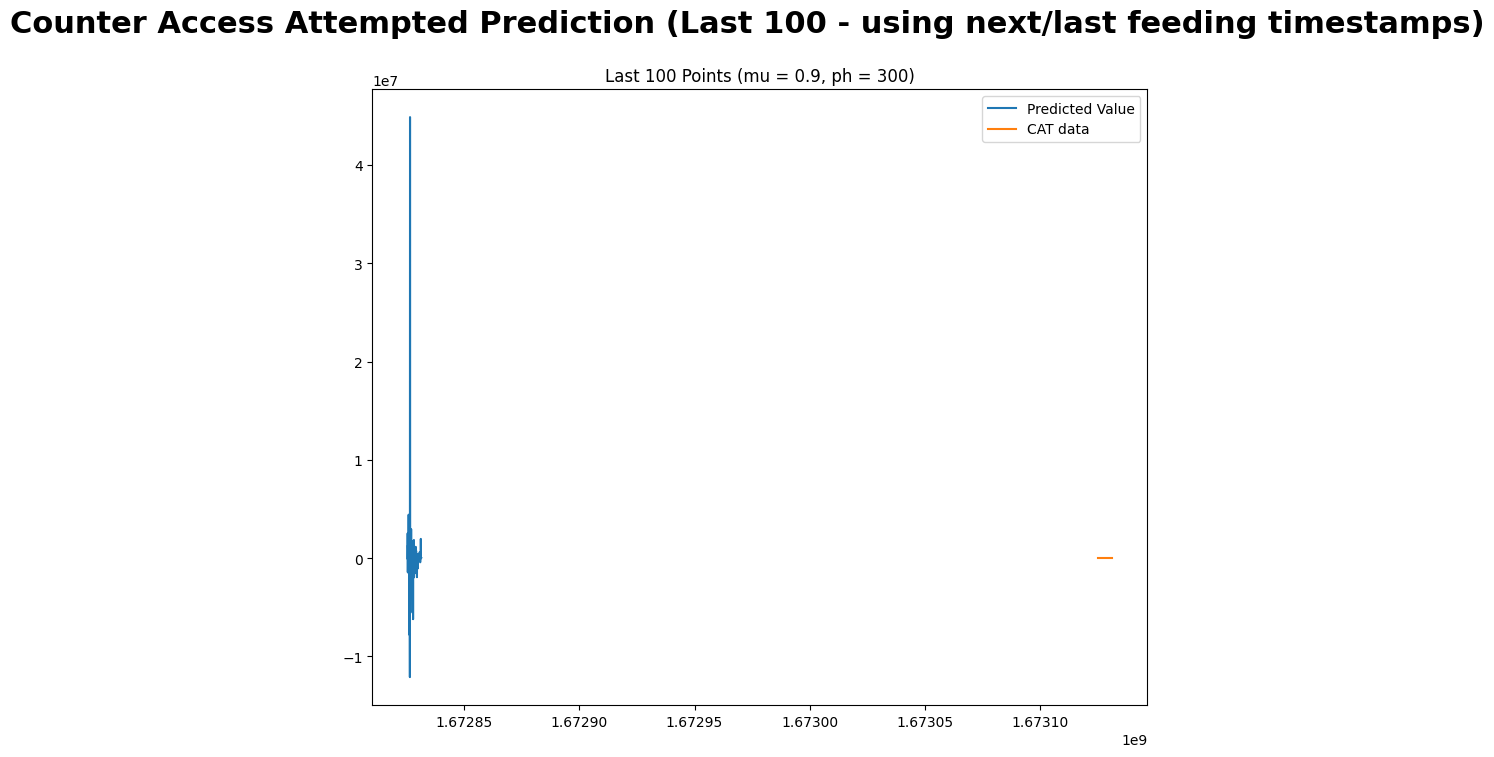

In [72]:
#Plot last 100 data points/predictions for mu = 0.01
fig1, ax2 = plt.subplots(figsize=(10, 8))
fig1.suptitle('Counter Access Attempted Prediction (Last 100 - using next/last feeding timestamps)', fontsize=22, fontweight='bold')
ax2.set_title(f'Last 100 Points (mu = {mu}, ph = {ph})')
ax2.plot(tp_pred[-100:], yp_pred[-100:], label='Predicted Value')
ax2.plot(ts.iloc[-100:,0], ys.iloc[-100:,0], label='CAT data')
ax1.set_xlabel('time (epoch)')
ax1.set_ylabel('true/false (0, 1)')
ax2.legend()

In [73]:
#Calculate MSE of predictions for the expanded data
print("MSE is", mse(ys['is_counter_access_attempted'][ph_index:5000+ph_index-1],yp_pred))

MSE is 2.8217842969534808e+20


Adding in the next/last feeding timestamps seemed to confuse the model comparatively.